# Notes on TensorFlow

In [2]:
import tensorflow as tf

#enable eager execution
tf.enable_eager_execution()

## Eager Execution
Evaluates operations immediately without building a graph.... more pythonic.

In [3]:
tf.executing_eagerly()

True

In [4]:
x = [[2.0]]
print(tf.matmul(x,x))

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


__tf.Tensor__ is a multidimensional array. Has a data type and a shape. Has many operations that consume and produce tensors. Object references concrete values instead of a symbolic handles to nodes in a computational graph.

With eager execution, we can evaluate and print the values of Tensors without breaking the program.


In [7]:
a = tf.constant([[1, 2],
                [3, 4]])
b = tf.add(a, 1)
print(a)
print(b) #broadcasting supported
print(a * b)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


### Dynamic Control Flow
Python functionality is available while the TF program is executing (unlike graphs executed in C++)

In [9]:
num = tf.constant(0)
for i in range(4):
    print(num)
    if num>2:
        print("3 Reached breaking")
        break
    num+=1  

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
3 Reached breaking


### Building a Model
We can compose models with __tf.keras.layers__ which contains many premade layers. We can  build layers with __tf.keras.layers.Layers__ base class.

In [ ]:
#Custom Layer
class MySimpleLayer(tf.keras.layers.Layer):
    def __init__(self, output_units):
        super(MySimpleLayer, self).__init__()
        self.output_units = output_units
    def build(self, input_shape):
        self.kernel = self.add_variable("kernel", [input_shape[-1], self.output_units])
    def call(self, input):
        return tf.matmul(input, self.kernel)
    
#Sequential Keras Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(784,)),
    tf.keras.layers.Dense(10)
])

#Custom Model Class
class Model(tf.keras.model):
    def __init__(self):
        super(Model, self).__init__()
        self.dense1 = tf.keras.layers.Dense(10,)
        self.dense2 = tf.keras.layers.Dense(10,)
    def call(self, input):
        result = self.dense1(input)
        result = self.dense2(result)
        result = self.dense2(result)
        return result
    

## Eager Training
__Computing Gradients__ uses automatic differentiation (iterative use of chain rule on computers applications of add, multiply, sin,cos to find derivative)

__tf.GradientTape__ is used in eager execution to trace operations for later derivation during backprop. All forward operations are recorded to the tape, later played back to compute gradient, and thrown away.

In [10]:
w = tf.Variable([[3.0]]) #variables exists outside of a session.run
with tf.GradientTape() as tape:
    loss = w*w  # = [[9.0]] = x^2  : Gradient ~~ [[6.0]] = 2*x
    
grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[6.]], shape=(1, 1), dtype=float32)


In [11]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

"""Creates a `Dataset` whose elements are slices of 
the given tensors."""
dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))

dataset = dataset.shuffle(1000).batch(32)

11493376/11490434 [==============================] - 1s 0us/step


In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
    tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])


optimizer = tf.train.AdamOptimizer()
loss_history = []

for (batch, (images, labels)) in enumerate(dataset.take(400)):
    if batch % 10 == 0:
        print('.', end='')
    #Forward Pass: run input through model, calculate loss(logits_preds, true)
    with tf.GradientTape() as tape:
        logits = model(images, training=True)
        loss_value = tf.losses.sparse_softmax_cross_entropy(labels,logits)
    #save the loss value for bookkeeping
    loss_history.append(loss_value.numpy())
    #Backwards pass -> run through tape and compute gradient for each model param
    grads = tape.gradient(loss_value, model.trainable_variables)
    #Update params with weighted gradient. (optimizer)
    optimizer.apply_gradients(zip(grads, model.trainable_variables),
                             global_step = tf.train.get_or_create_global_step())


........................................

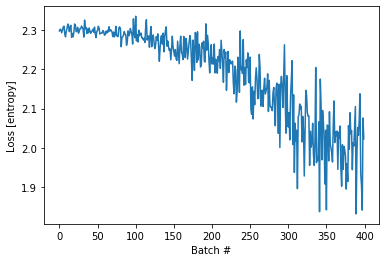

In [16]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.show()

### Derivatives in TensorFlow

__Higher order derivatives__

In [21]:
#tf.GradientTape()
"""
Operations are recorded if at least one input is being watched. 
Trainable variables are automatically watched (trainable=True)

the GradientTape.watch() method can be used to manually 
set a variable to be watched 

Gradients can be nested to compute higher order gradients.
"""
x = tf.constant(3.)
with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
        gg.watch(x)
        y = x * x
    #unravel the inner gradient tape
    #evaluate gradient with val x
    dy_dx = gg.gradient(y, x)
dy_dx2 = g.gradient(dy_dx, x)
print(dy_dx) # f'(x) = 2x
print(dy_dx2) # f''(x) = 2

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


__Computing Multiple gradients from a single pass__

In [18]:
"""
Resources held by GradientTape are released upon call of the 
GradientTape.gradient() method. Compute multiple gradients over 
same computation with persistent gradient tape
"""
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as g:
    g.watch(x) #manually set x to be watched
    y = x * x   # x^2
    z = y * y  #still a fuction of x -> x^4
    
#can think of    
dz_dx = g.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
dy_dx = g.gradient(y, x)  # 6.0
print(dz_dx)
print(dy_dx)
del g  # Drop the reference to the tape

tf.Tensor(108.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


__Useful GradientTape Methods__

In [ ]:
GradientTape.gradient(target, sources)
GradientTape.jacobian(target, sources)
GradientTape.reset()
GradientTape.watch()

## Variables and Optimizers

__tf.Variable__ stores mutable __tf.Tensor__ values accessed during training to make differentiation easier. Model parameters can be encapsulated within classes as variables.

In [27]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
    def call(self, inputs):
        return inputs * self.W + self.B
    
    
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random_normal([NUM_EXAMPLES])
noise = tf.random_normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

#custom loss function
def loss(model, inputs, targets):
    error = model(inputs)-targets
    #reduce_mean() ~compute mean across dimensions of a tensor
    #returns one value without axis=
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

model = Model()
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

for i in range(300):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads,[model.W, model.B]), 
                              global_step=tf.train.get_or_create_global_step())
    if i % 20 == 0:  
        print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))
print('W:',model.W.numpy(),'B:', model.B.numpy())

Loss at step 000: 66.657
Loss at step 020: 30.104
Loss at step 040: 13.910
Loss at step 060: 6.734
Loss at step 080: 3.554
Loss at step 100: 2.144
Loss at step 120: 1.519
Loss at step 140: 1.242
Loss at step 160: 1.120
Loss at step 180: 1.065
Loss at step 200: 1.041
Loss at step 220: 1.030
Loss at step 240: 1.026
Loss at step 260: 1.023
Loss at step 280: 1.022
W: 2.9749281 B: 2.032821


## Smart Memory Management
In eager execution,  lifetime of state object is determined if there exists a reference pointing to the object. The object will be removed when the reference is deleted.

In [ ]:
if tf.test.is_gpu_available():
    with tf.device("gpu:0"):
        v = tf.Variable(tf.random_normal([1000, 1000]))
        v = None  # v no longer takes up GPU memory

## Object-Based Saving
__tf.train.Checkpoint__ can save and restore __tf.Variable__ to and from checkpoints.

In [31]:
"""
`Checkpoint`'s constructor accepts keyword arguments whose values are types
that contain trackable state, such as `tf.compat.v1.train.Optimizer`
implementations, `tf.Variable`, `tf.keras.Layer` implementations, or
`tf.keras.Model` implementations. It saves these values with a checkpoint, and
maintains a `save_counter` for numbering checkpoints.
"""

x = tf.Variable(5.)
checkpoint = tf.train.Checkpoint(x=x)

x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')


x.assign(11.)  # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>
